# Politeness strategies in MT-mediated communication

In this notebook, we demo how to extract politeness strategies using ConvoKit's `PolitenessStrategies` module both in English and in Chinese. We will make use of this functionality to assess the degree to which politeness strategies are preserved in machine-translated texts.

The politeness strategies considered are adapted from operationalizations in the following papers:

- English: [A computational approach to politeness with application to social factors](https://www.cs.cornell.edu/~cristian/Politeness.html), [The politeness Package: Detecting Politeness in Natural Language](https://journal.r-project.org/archive/2018/RJ-2018-079/RJ-2018-079.pdf)

- Chinese: [Studying Politeness across Cultures using English Twitter and Mandarin Weibo](https://dl.acm.org/doi/abs/10.1145/3415190)



In [1]:
import os
from collections import defaultdict, Counter
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import spacy

from convokit import Corpus, Speaker, Utterance, download
from convokit import TextParser, PolitenessStrategies

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## 1. Preparing diagnostic test sets 

We sample utterances from Wikipedia Talkpages discussions in both English and Chinese. In particular, we use the medium-sized `wiki-corpus` shipped by ConvoKit as the source for sampling English utterances (as shown below), and we sampled a subset of utterances from [WikiConv](https://www.cs.cornell.edu/~cristian/index_files/wikiconv-conversation-corpus.pdf) (Chinese) as shared in [figshare](https://figshare.com/articles/dataset/WikiConv_-_Chinese/7376012). 

For those who would like to skip the preparatory steps and go straight to our analysis exploring how to assess the permeability of politeness signals in machine-translated communication ([Part 2 of this notebook](#2.-Computing-permeability-for-politeness-strategies)), we have made the sampled corpora directly downloadable via ConvoKit as `wiki-sampled-en-corpus` and `wiki-sampled-zh-corpus`.



### 1.1. English data: `wiki-corpus`

The medium-sized Wikipedia dataset is provided by ConvoKit as `wiki-corpus` ([documentation](https://convokit.cornell.edu/documentation/wiki.html)). Note that ConvoKit also offers a more complete collection of Wikipedia Talkpage discussions: [the Cornell Wikiconv Dataset](https://convokit.cornell.edu/documentation/wikiconv.html). We choose to use `wiki-corpus` as it is already sufficiently large for our purpose. 

To load the corpus, see options in the cell below. 

In [2]:
# MASK this out
WIKI_ROOT_DIR = "/reef/liye_exp/thesis/MT_styles/data/politeness/wiki-corpus/wiki-corpus/"

In [3]:
# OPTION 1: DOWNLOAD CORPUS 
# UNCOMMENT THESE LINES TO DOWNLOAD CORPUS
# DATA_DIR = '<YOUR DIRECTORY>'
# WIKI_ROOT_DIR = download('wiki-corpus', data_dir=DATA_DIR)

# OPTION 2: READ PREVIOUSLY-DOWNLOADED CORPUS FROM DISK
# UNCOMMENT THIS LINE AND REPLACE WITH THE DIRECTORY WHERE THE WIKI-CORPUS IS LOCATED
# WIKI_ROOT_DIR = '<YOUR DIRECTORY>'

corpus = Corpus(filename=WIKI_ROOT_DIR)

# load parses
corpus.load_info('utterance',['parsed'])

/home/liye/github/Cornell-Conversational-Analysis-Toolkit/convokit/model/corpus.py:1056: FutureWarning: set_info() is deprecated and will be removed in a future release. Use add_meta() instead.


In [4]:
# Overall stats of the dataset 
corpus.print_summary_stats()

Number of Speakers: 38462
Number of Utterances: 391294
Number of Conversations: 125292


#### Extracting strategies for sampling

In the case when the corpus is not dependency parsed, it will need to go through an additional step of parsing, which can be achieved via `TextParser`. See [this demo](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/politeness-strategies/politeness_demo.ipynb) for an example. As the `wiki-corpus` ships with pre-computed dependency parses (which we already loaded as you may notice), we can go straight to politeness strategy extraction. 

Here, we will focus on a set of local strategies, and hence specify that we will want to extract with strategy collection _politeness_local_. For other available options, refer to the [documentation](https://convokit.cornell.edu/documentation/politenessStrategies.html) for details.

In [6]:
ps_local = PolitenessStrategies(strategy_collection="politeness_local", verbose=10000)

# By default, strategy extraction results are saved under "politeness_strategies". 
corpus = ps_local.transform(corpus, markers=True)

10000/391294 utterances processed
20000/391294 utterances processed
30000/391294 utterances processed
40000/391294 utterances processed
50000/391294 utterances processed
60000/391294 utterances processed
70000/391294 utterances processed
80000/391294 utterances processed
90000/391294 utterances processed
100000/391294 utterances processed
110000/391294 utterances processed
120000/391294 utterances processed
130000/391294 utterances processed
140000/391294 utterances processed
150000/391294 utterances processed
160000/391294 utterances processed
170000/391294 utterances processed
180000/391294 utterances processed
190000/391294 utterances processed
200000/391294 utterances processed
210000/391294 utterances processed
220000/391294 utterances processed
230000/391294 utterances processed
240000/391294 utterances processed
250000/391294 utterances processed
260000/391294 utterances processed
270000/391294 utterances processed
280000/391294 utterances processed
290000/391294 utterances proc

#### Computing strategy prevalance 

We can first take a glimpse over utterance-level strategy prevalence, i.e., proportion of utterances in the dataset that use the politeness strategy. This can be easily done using `summarize()`. 

In [7]:
df_prevalence = ps_local.summarize(corpus)
df_prevalence

Actually        0.092892
Adverb.Just     0.135192
Affirmation     0.068373
Apology         0.039078
By.The.Way      0.015546
Conj.Start      0.134996
Filler          0.004140
For.Me          0.011099
For.You         0.011784
Gratitude       0.202492
Greeting        0.073242
Hedges          0.198127
Indicative      0.015620
Please          0.046149
Please.Start    0.041657
Reassurance     0.016573
Subjunctive     0.025725
Swearing        0.004051
dtype: float64

#### Sampling 

To assess permeability of these strategies, we sample 1000 instances for each strategy. The results will be saved to a smaller `wiki-sampled-en` corpus, which may be directly downloaded via ConvoKit if one wants to skip the intermediate steps (which will take a while to run) see [Part 2 of this notebook](#2.-Computing-permeability-for-politeness-strategies). 

In [8]:
# utterance-level strategy uses
df_feat = pd.DataFrame.from_dict({utt.id: utt.meta['politeness_strategies'] \
                                  for utt in corpus.iter_utterances()}, orient='index')

In [9]:
# sampling from least common to most
sorted_strategies = df_prevalence.sort_values().index
sampled_ids, samples = set(), []

for k in sorted_strategies:
    df_sample = df_feat[(~df_feat.index.isin(sampled_ids)) & (df_feat[k]==1)].sample(1000, random_state=42)
    df_sample['strategy'] = k
    samples.append(df_sample[['strategy']])
    sampled_ids.update(df_sample.index)
    
df_en_sample = pd.concat(samples)

In [18]:
# saving as a convokit corpus
for i, info in df_en_sample.itertuples():
    utt = corpus.get_utterance(i)
    utt.add_meta('selected', True)
    utt.add_meta('strategy', info)

# filter only selected utterances 
# (not that this does not maintain conversation structure)
wiki_sampled_en = corpus.filter_utterances_by(lambda utt:'selected' in utt.meta and utt.meta['selected'])

#### Translating 

To determine the degree to which politeness markers are perserved in translation, we will make comparisons between original and translated texts. To set it up, we two rounds of translations, forming a English -> Chinese -> English loop, i.e., we first translate the English texts into Chinese, and then translate the Chinese translations back into English. 

We use [EasyNMT](https://github.com/UKPLab/EasyNMT) to perform translations between English and Chinese, using models from [Opus-MT](https://github.com/Helsinki-NLP/Opus-MT) from [Helsinki-NLP](https://blogs.helsinki.fi/language-technology/). 

In [21]:
from easynmt import EasyNMT

In [22]:
# texts to be translated
df_utts = wiki_sampled_en.get_utterances_dataframe(exclude_meta=True)

# translation model
model = EasyNMT('opus-mt', cache_folder="/belafonte_sauna/liye_translations/easynmt/")

In [23]:
df_utts['en-zh'] = model.translate(list(df_utts['text']), \
                                   target_lang='zh', \
                                   source_lang='en', \
                                   show_progress_bar=True,
                                   batch_size=8, \
                                   perform_sentence_splitting=False)

100%|██████████| 18000/18000.0 [2:28:46<00:00,  2.02it/s]


In [24]:
df_utts['en-back'] = model.translate(list(df_utts['en-zh']), \
                                   target_lang='en', \
                                   source_lang='zh', \
                                   show_progress_bar=True,
                                   batch_size=8, \
                                   perform_sentence_splitting=False)

100%|██████████| 18000/18000.0 [1:09:48<00:00,  4.30it/s]


We add these translated texts as meta data to our sampled corpus, and parse them to prepare for later strategy extraction.

In [46]:
from convokit.text_processing.textParser import TextParser

In [47]:
for row in df_utts[['text', 'en-zh', 'en-back']].itertuples():
    idx, trans, backtrans = row[0], row[2], row[3]
    utt = wiki_sampled_en.get_utterance(idx)
    utt.add_meta('en-zh', trans)
    utt.add_meta('en-back', backtrans)

In [48]:
# parser to parse back-translated English texts 
en_parser = TextParser(output_field='en_parsed', input_field='en-back', \
                       verbosity=5000)

# parer to parse translated texts in Chinese
spacy_zh = spacy.load('zh_core_web_sm', disable=['ner'])
zh_parser = TextParser(output_field='zh_parsed', input_field='en-zh', \
                       spacy_nlp=spacy_zh, verbosity=5000)

In [49]:
wiki_sampled_en = en_parser.transform(wiki_sampled_en)
wiki_sampled_en = zh_parser.transform(wiki_sampled_en)

5000/18000 utterances processed
10000/18000 utterances processed
15000/18000 utterances processed
18000/18000 utterances processed
5000/18000 utterances processed
10000/18000 utterances processed
15000/18000 utterances processed
18000/18000 utterances processed


In [28]:
# We can then save the corpus using wiki_sampled_en.dump(YOUR_OUT_DIR)

### 1.2 Chinese data: [WikiConv](https://www.cs.cornell.edu/~cristian/index_files/wikiconv-conversation-corpus.pdf)

For the Chinese data, we start utterances from [WikiConv](https://figshare.com/articles/dataset/WikiConv_-_Chinese/7376012) and similarly sampled 1000 instances for a subset of strategies from the collection "_politeness-cscw-zh_". The corpus is saved as `wiki-sampled-zh-corpus`, with all textual data (i.e., both the original utterance texts and the the corresponding translations) tokenized and parsed.  

In [26]:
wiki_sampled_zh = Corpus(download('wiki-sampled-zh-corpus'))

Dataset already exists at /belafonte_sauna/liye_translations/convokit_mt/test/wiki-sampled-en-corpus


In [27]:
# Inspect the meta data avaible, should have the following:
# 'parsed' contains the dependency parses for the utterance text 
# 'zh-en' and 'zh-back' contains the translations and back translations for utterance texts respectively 
# 'en_parsed' and 'zh_parsed' contain the respective parses, which we will use for strategy extractions
wiki_sampled_zh.meta_index

{'utterances-index': {'is-admin': ["<class 'bool'>"], 'parsed': ["<class 'list'>"], 'politeness_strategies': ["<class 'dict'>"], 'politeness_markers': ["<class 'dict'>"], 'selected': ["<class 'bool'>"], 'strategy': ["<class 'str'>"], 'en-zh': ["<class 'str'>"], 'en-back': ["<class 'str'>"], 'en_parsed': ["<class 'list'>"], 'zh_parsed': ["<class 'list'>"]}, 'speakers-index': {'is-admin': ["<class 'bool'>"], 'edit-count': ["<class 'str'>"]}, 'conversations-index': {}, 'overall-index': {}, 'version': 1, 'vectors': []}

## 2. Computing permeability for politeness strategies 

With the two sampled datasets tokenized and parsed, we are now ready to the degree to which strategies are perserved vs. lost in different translation directions. 

We make two types of comparisons:

* First, we consider a direct comparison between the original vs. translated texts. In particular, we check strategies used in utterances in English texts and Chinese texts with respective politeness strategy operationalizations to make comparisons. 

* Second, we consider comparing the original vs. the backtranslated texts using the same strategy operationalization and compare strategies detected.  

In [40]:
# Download the data if Part 1 of the notebook is skipped 

# replace with where you'd like the corpora to be saved 
DATA_DIR = '/belafonte_sauna/liye_translations/convokit_mt/test/'

wiki_sampled_en = Corpus(download('wiki-sampled-en-corpus', data_dir=DATA_DIR))
wiki_sampled_zh = Corpus(download('wiki-sampled-zh-corpus', data_dir=DATA_DIR))

Dataset already exists at /belafonte_sauna/liye_translations/convokit_mt/test/wiki-sampled-en-corpus
Dataset already exists at /belafonte_sauna/liye_translations/convokit_mt/test/wiki-sampled-zh-corpus


In [41]:
wiki_sampled_en.print_summary_stats()

Number of Speakers: 7290
Number of Utterances: 18000
Number of Conversations: 16583


In [42]:
wiki_sampled_zh.print_summary_stats()

Number of Speakers: 2933
Number of Utterances: 12000
Number of Conversations: 1


### Extracting strategies 

As a first step, we extract strategies for all translations and back-translations. We will need two politeness strategy transformers: 

* for texts in English, we will again use the strategy collection _politeness_local_ 
* for texts in Chinese, we will be using the strategy collection _politeness-cscw-zh_.

More details of different politeness strategy collections can be found at the [documentation page]( https://convokit.cornell.edu/documentation/politenessStrategies.html).

In [43]:
ps_zh = PolitenessStrategies(parse_attribute_name='zh_parsed', \
                             strategy_attribute_name="zh_strategies", \
                             strategy_collection="politeness_cscw_zh", 
                             verbose=5000)

ps_en = PolitenessStrategies(parse_attribute_name='en_parsed', \
                             strategy_attribute_name="en_strategies", \
                             strategy_collection="politeness_local",
                             verbose=5000)

In [44]:
# extracting for English samples
wiki_sampled_en = ps_zh.transform(wiki_sampled_en)
wiki_sampled_en = ps_en.transform(wiki_sampled_en)

5000/18000 utterances processed
10000/18000 utterances processed
15000/18000 utterances processed
5000/18000 utterances processed
10000/18000 utterances processed
15000/18000 utterances processed


In [45]:
# extracting for Chinese samples
wiki_sampled_zh = ps_zh.transform(wiki_sampled_zh)
wiki_sampled_zh = ps_en.transform(wiki_sampled_zh)

5000/12000 utterances processed
10000/12000 utterances processed
5000/12000 utterances processed
10000/12000 utterances processed


### Making comparisons

We consider permeability of a politeness strategy _s_ as the percentage utterances in a given collection containing such markers for which the translated version also contains (potentially different) markers from the same set.
 
As mentioned earlier, we estimate permeability both with translations and backtranslations. Note that each approach has its own limitations, and thus both of them are at best _proxies_ for strategy permeability and should be not read as the groundtruth values.

In [46]:
# Mapping between strategy names in different collections 
# Note that the collections are not exactly equivalent, 
# i.e., there are strategies we can't find a close match between the two collections

en2zh = {'Actually': 'factuality',
         'Adverb.Just': None,
         'Affirmation': 'praise',
         'Apology': 'apologetic',
         'By.The.Way': 'indirect_btw',
         'Conj.Start': 'start_so',
         'Filler': None,
         'For.Me': None,
         'For.You': None,
         'Gratitude': 'gratitude',
         'Greeting':'greeting',
         'Hedges':'hedge',
         'Indicative':'can_you',
         'Please': 'please',
         'Please.Start': 'start_please',
         'Reassurance': None,
         'Subjunctive': 'could_you',
         'Swearing': 'taboo'
       }

zh2en = {v:k for k,v in en2zh.items() if v}

In [47]:
# add utterance-level assessing result to utterance metadata for the English corpus
for utt in wiki_sampled_en.iter_utterances():
    
    # strategy names in English and Chinese 
    en_name = utt.retrieve_meta('strategy')
    zh_name = en2zh[en_name]
    
    # translations
    if zh_name:
        trans_status = utt.retrieve_meta('zh_strategies')[zh_name]
        utt.add_meta('translation_result', trans_status)
    else:
        # when a comparison isn't applicable, we use the value -1 
        utt.add_meta('translation_result', -1)
    
    # back translations 
    backtrans_status = utt.retrieve_meta('en_strategies')[en_name]
    utt.add_meta('backtranslation_result', backtrans_status)

In [48]:
# add utterance-level assessing result to utterance metadata for the Chinese corpus
for utt in wiki_sampled_zh.iter_utterances():
    
    # strategy names in English and Chinese 
    zh_name = utt.retrieve_meta('strategy')
    en_name = zh2en[zh_name]
    
    # translations
    if en_name:
        trans_status = utt.retrieve_meta('en_strategies')[en_name]
        utt.add_meta('translation_result', trans_status)
    
    # back translations 
    backtrans_status = utt.retrieve_meta('zh_strategies')[zh_name]
    utt.add_meta('backtranslation_result', backtrans_status)

We can then export these utterance-level assessing results to pandas DataFrames (via `get_attribute_table`) for easy aggregation and plotting. The utterance metadata we need are:

    * strategy: the strategy to be checked for the utterance 
    * translation_result: whether the checked strategy remains in the translated text
    * backtranslation_result: whether the checked strategy remains in the back-translated text

#### A. English -> Chinese

In [49]:
# results for the English corpus 
res_df_en = wiki_sampled_en.get_attribute_table(obj_type='utterance', \
                                                attrs=['strategy', \
                                                       'translation_result', \
                                                       'backtranslation_result'])

res_df_en.columns = ['strategy', 'en->zh', 'en->zh->en']

# strategy-level permeability, -1 means the strategy is not applicable 
permeability_df_en = res_df_en.groupby('strategy').sum() / 1000

In [50]:
# As a reference, we include permeability computed through an informal small-scale human annotations 
# (50 instances, one annotator)
reference = {'Actually': 0.7, 'Adverb.Just': 0.62, 'Affirmation': 0.8, 'Apology': 0.94, 'By.The.Way': 0.42,
             'Conj.Start': 0.66, 'Filler': 0.58, 'For.Me': 0.62, 'For.You': 0.52, 'Gratitude': 0.86,
             'Greeting': 0.52, 'Hedges': 0.68, 'Indicative': 0.64, 'Please': 0.72, 'Please.Start': 0.82,
             'Reassurance': 0.88, 'Subjunctive': 0.0, 'Swearing': 0.3}

permeability_df_en['ref'] = [reference[name] for name in permeability_df_en.index]

In [51]:
# As further context, we can inlcude information about strategy prevalence on our plot
prevalence_en = dict(df_prevalence*100)
permeability_df_en.index = [f"{name} ({prevalence_en[name]:.1f}%)" for name in permeability_df_en.index]

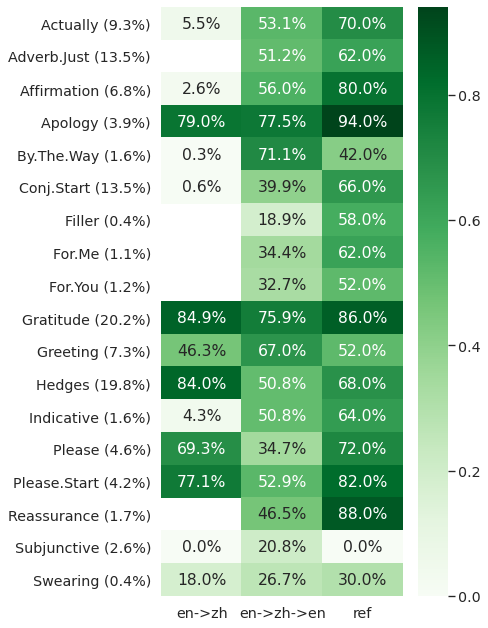

In [54]:
plt.figure(figsize=(5, 10))
sns.set(font_scale=1.2)

# cells that are not applicable are masked in white
with sns.axes_style("white"):
    sns.heatmap(permeability_df_en, annot=True, cmap="Greens", fmt=".1%", mask=permeability_df_en==-1)

#### B. Chinese -> English

In [55]:
# results for the English corpus 
res_df_zh = wiki_sampled_zh.get_attribute_table(obj_type='utterance', \
                                                attrs=['strategy', \
                                                       'translation_result', \
                                                       'backtranslation_result'])

# convert names to make it easier to compare between directions 
res_df_zh['strategy'] = res_df_zh['strategy'].apply(lambda name:zh2en[name])

res_df_zh.columns = ['strategy', 'zh->en', 'zh->en->zh'] 
permeability_df_zh = res_df_zh.groupby('strategy').sum() / 1000

In [56]:
# as the original dataset for the Chinese corpus is quite large
# we present strategy prevalence results directly

prevalence_zh = {'apologetic': 0.6, 'can_you': 0.3, 'could_you': 0.0, 
                 'factuality': 0.4,'gratitude': 3.1, 'greeting': 0.0, 
                 'hedge': 42.8, 'indirect_btw': 0.1,
                 'praise': 0.4, 'please': 25.4, 
                 'start_please': 17.7, 'start_so': 0.7, 'taboo': 0.4}

permeability_df_zh.index = [f"{name} ({prevalence_zh[en2zh[name]]:.1f}%)" for name in permeability_df_zh.index]

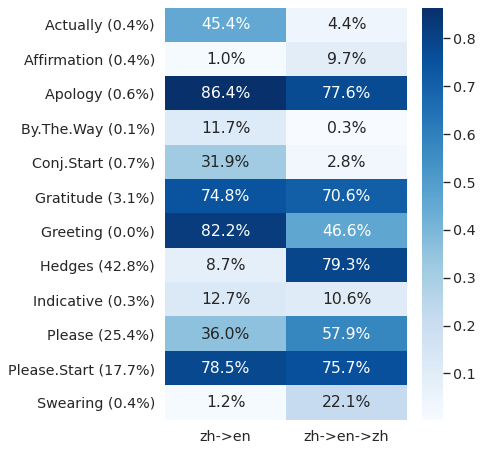

In [57]:
plt.figure(figsize=(5, 7))
sns.set(font_scale=1.2)
with sns.axes_style("white"):
    sns.heatmap(permeability_df_zh, annot=True, cmap="Blues", fmt=".1%")